In [20]:
import pathlib
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
from pickle import dump


from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Layer
from  tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import Model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [21]:
dir = dict(output = pathlib.Path("./Output"))

# For plot customisation
sns.set_context('notebook')
sns.set_style('darkgrid')
plt.rc('axes', linewidth=1)
plt.rc('axes', edgecolor='k')
plt.rc('figure', dpi=100)
palette = sns.color_palette('deep')

Load the results of the data assimilation

# Load the data


In [22]:

xa = np.load(dir['output'] / 'xa.npy')
xf = np.load(dir['output'] / 'xf.npy')
xt = np.load(dir['output'] / 'xt.npy')
err = xa-xf

In [23]:
from Model.lorenz96 import l96
Nx = 40
dt = 0.05
F = 8
phi = l96(Nx, dt, F)

In [24]:
from Model.lorenz96_cubic import l96cb

Nx = 40
dt = 0.05
F = 8
diffusion = 0.025
friction = 1.0
tmodel = l96cb(Nx, dt, F, diffusion, friction)

In [25]:
learning = 'analysis'

if learning == 'analysis':
    x = xa

else:
     x = xt #learn on the true error

In [26]:
xf = x + phi(x)
err = x[1:] - xf[:-1]

## Diagnostics

In [27]:
def scatter_plot(x,y,ax=None):
    ax = sns.regplot(x=x, y=y, ax=ax)
    r2 = r2_score(x, y)
    mse = mean_squared_error(x, y)
    ax.set_title(f'R2={r2:.2f}, MSE={mse:.2e}')
    return ax

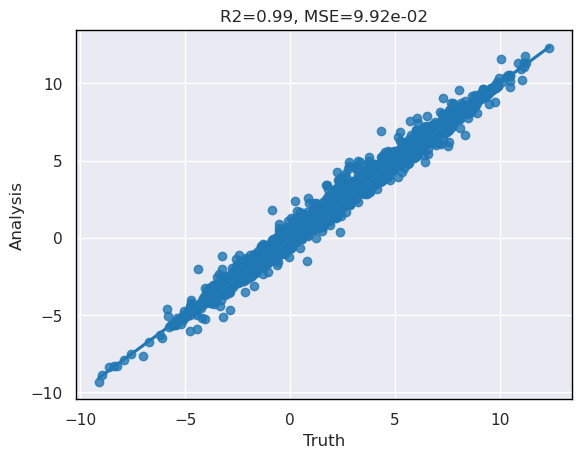

In [28]:
ax = scatter_plot (xt[:,20], xa[:,20])
ax.set_xlabel('Truth')
ax.set_ylabel('Analysis');
plt.savefig('Figures/scatter_analysis')

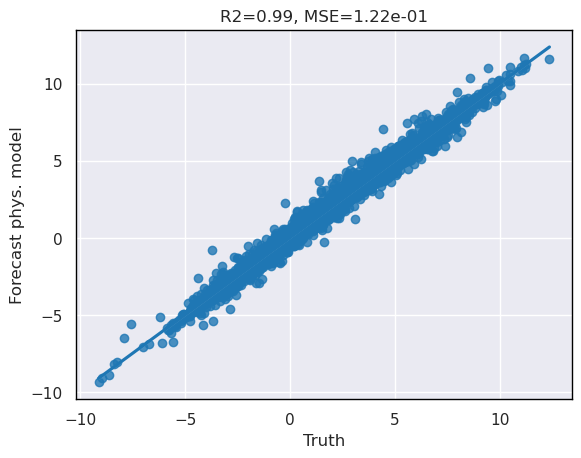

In [29]:
ax = scatter_plot (xt[1:,20], xf[:-1,20])
ax.set_xlabel('Truth')
ax.set_ylabel('Forecast phys. model');
plt.savefig('Figures/scatter_phiforecast')


In [30]:
xp1 = np.roll(x, shift=1, axis=-1)
xp2 = np.roll(xp1, shift=1, axis=-1)
xp3 = np.roll(xp2, shift=1, axis=-1)
xm1 = np.roll(x, shift=-1, axis=-1)
xm2 = np.roll(xm1, shift=-1, axis=-1)
p1 = (xp2*x*(xm1-xp3)-xp1*xm1*(xm2-xp2))        

<AxesSubplot: >

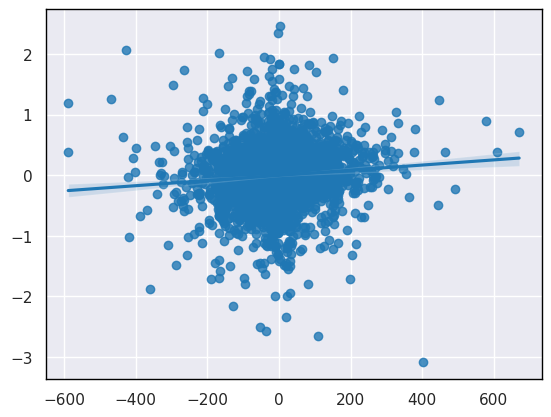

In [33]:
sns.regplot(x=p1[1:,20],y=err[:,20])

## Build the NN model

In [34]:
class Periodic1DPadding(Layer):
    """Add a periodic padding to the output
    # Arguments
        padding_size: tuple giving the padding size (left, right)
    # Output Shape
        input_shape+left+right
    """


    def __init__ (self, padding_size, **kwargs):
        super(Periodic1DPadding, self).__init__(**kwargs)
        if isinstance(padding_size, int):
            padding_size = (padding_size, padding_size)
        self.padding_size = tuple(padding_size)

    def compute_output_shape( self, input_shape ):
        space = input_shape[1:-1]
        if len(space) != 1:
            raise ValueError ('Input shape should be 1D with channel at last')
        new_dim = space[0] + np.sum(self.padding_size)
        return (input_shape[0],new_dim,input_shape[-1])



    def build( self , input_shape):
        super(Periodic1DPadding,self).build(input_shape)

    def call( self, inputs ):
        vleft, vright = self.padding_size
        leftborder = inputs[:, -vleft:, :]
        rigthborder = inputs[:, :vright, :]
        return K.concatenate([leftborder, inputs, rigthborder], axis=-2)

In [35]:
def buildmodel(archi, m=40, reg=1e-5, batchlayer=1):

    inputs = Input(shape=(m,1))
    border = int(np.sum(np.array([kern//2 for nfil,kern,activ in archi])))
    x = Periodic1DPadding(padding_size=border)(inputs)
    x = BatchNormalization()(x)
    for i, (nfil, kern, activ) in enumerate(archi):
        if i == batchlayer:
            x = BatchNormalization()(x)
        x = Conv1D(nfil, kern, activation=activ)(x)
    output= Conv1D(1,1,activation='linear', kernel_regularizer=regularizers.l2(reg))(x)
    return Model(inputs,output)


In [36]:
archi = [(40, 7, 'tanh'),
         (20, 1, 'tanh')]

In [37]:
model = buildmodel(archi)

2022-12-18 10:22:53.058750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the model

In [38]:
X = x[0:-1]
y = err
frac_train = .8

itrain = int(frac_train*X.shape[0])

Xtrain, ytrain = X[:itrain], y[:itrain]
Xval, yval = X[itrain:], y[itrain:]

print(f'Total number of samples: {X.shape[0]}')
print(f'Number of training samples: {Xtrain.shape[0]}')
print(f'Number of validationsamples: {Xval.shape[0]}')
print(f'Number of input feature: {Xval.shape[1]}')

Total number of samples: 4999
Number of training samples: 3999
Number of validationsamples: 1000
Number of input feature: 40


In [39]:
scaler_x = StandardScaler().fit(Xtrain)
scaler_y = StandardScaler().fit(ytrain)


In [40]:
model.compile(loss='mse', optimizer='adam')

In [41]:
history = model.fit(scaler_x.transform(Xtrain), scaler_y.transform(ytrain), 
                    epochs=200, 
                    batch_size=256, 
                    validation_data = (scaler_x.transform(Xval), scaler_y.transform(yval)),
                    verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 25ms/step - loss: 1.3902 - val_loss: 0.6849
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 1.0312 - val_loss: 0.6792
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 1.0075 - val_loss: 0.6804
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 0.9933 - val_loss: 0.6784
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.9879 - val_loss: 0.6784
Epoch 6/200
16/16 [==============================] - 0s 13ms/step - loss: 0.9842 - val_loss: 0.6787
Epoch 7/200
16/16 [==============================] - 0s 14ms/step - loss: 0.9816 - val_loss: 0.6769
Epoch 8/200
16/16 [==============================] - 0s 13ms/step - loss: 0.9796 - val_loss: 0.6785
Epoch 9/200
16/16 [==============================] - 0s 14ms/step - loss: 0.9778 - val_loss: 0.6773
Epoch 10/200
16/16 [==============================] - 0s 14ms/step - loss: 0.9762 - val_loss: 0.6777

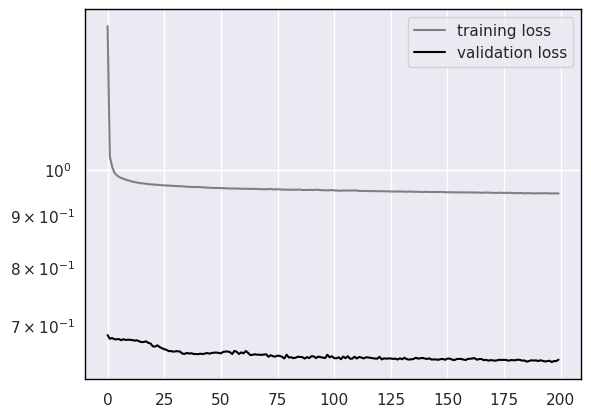

In [42]:
plt.semilogy(history.history['loss'], color='gray', label='training loss')
plt.semilogy(history.history['val_loss'], color='black', label='validation loss')
plt.legend()

In [44]:
if learning=='analysis':
    name = 'damodel'
else:
    name = 'true_model'
print(name)

damodel


In [45]:
# TODO model+scale save wrapper

    
model.save(dir['output'] / f'{name}_nn')
dump(scaler_x, open(dir['output'] / f'{name}_scalerx', 'wb'))
dump(scaler_y, open(dir['output'] / f'{name}_scalery', 'wb'))

INFO:tensorflow:Assets written to: Output/damodel_nn/assets


INFO:tensorflow:Assets written to: Output/damodel_nn/assets


## Validate the model (offline)

In [46]:
ypredict = scaler_y.inverse_transform(model.predict(scaler_x.transform(X)).squeeze())

157/157 [==============================] - 0s 1ms/step


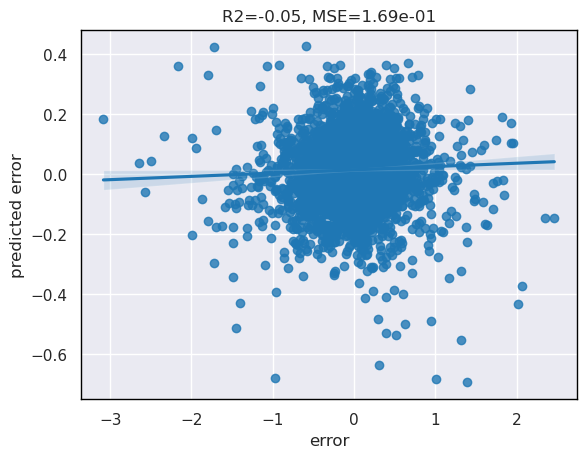

In [47]:
ax = scatter_plot (err[1:,20], ypredict[:-1,20])
ax.set_xlabel('error')
ax.set_ylabel('predicted error');

#plt.savefig('Figures/scatter_analysis')
